# 1. Check dataset

In [16]:
from pathlib import Path
import pandas as pd
import numpy as np
dataset_dir = Path('/home/glyin/Projects/Crop_Classification/Sen4AgriNet/S4A-Models/data/processed_merged')
datapaths = list(dataset_dir.rglob('*.csv'))
for datapath in datapaths:
    
    if 'CTC' in str(datapath):
        continue
    print(datapath)
    df = pd.read_csv(datapath)
    # extract cols Band_1, Band_2, Band_3, Band_4, Band_5, Band_6, Band_7, Band_8, Band_9, Band_10, Band_11, Band_12, Band_13, Band_14
    df = df[['Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 'Band_6', 'Band_7', 'Band_8', 'Band_9', 'Band_10', 'Band_11', 'Band_12', 'Band_13', 'Band_14']]
    # convert to numpy array
    df = df.to_numpy()
    # convert to float32
    df = df.astype(np.float32)
    print(df.shape)
    break

/home/glyin/Projects/Crop_Classification/Sen4AgriNet/S4A-Models/data/processed_merged/16644_RB966928.csv
(14973, 14)


In [47]:
from scipy.io import loadmat
import numpy as np
from __future__ import annotations

from typing import Any

import matplotlib.pyplot as plt
def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: tuple[float, float] | None = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
def load_tiles_and_band_names_from_mat(path):
    data = loadmat(path)
    tiles = {}
    band_names = []

    for key in data.keys():
        if key.startswith('tile_'):
            try:
                min_x, max_x, min_y, max_y = data[key][0][0][0][0][0]
                size = data[key][0][0][1]

                # 处理嵌套的二维数组，提取实际的 (height, width)
                height, width = size[0][0], size[0][1]

                img = np.transpose(data[key][0][0][2], (0, 2, 1))  # 将图像数据转置为 (bands, height, width)

                # 检查 img 是否是三维数据
                if img.ndim != 3:
                    print(f"Warning: Unexpected image dimensions in {key}: {img.shape}")
                    continue

                tiles[key] = {
                    'bbox': (min_x, max_x, min_y, max_y),
                    'size': (height, width),
                    'img': img
                }
            except IndexError as e:
                print(f"Error processing tile {key} in {path}: {e}")
                continue

    if 'band_names' in data:
        band_names = data['band_names'].flatten().tolist()
    else:
        band_names = [f'Band_{i+1}' for i in range(14)]

    return tiles, band_names
mat_file_path = '/home/glyin/Projects/Crop_Classification/Sen4AgriNet/S4A-Models/data/Raw_Data/Alldata_2024-01-06_to_2024-01-12.mat'
tiles, band_names = load_tiles_and_band_names_from_mat(mat_file_path)

In [85]:
from PIL import Image
img = tiles['tile_0']['img'][:12]
def normalize_img(img):
    min_val = img.min(axis=(1, 2), keepdims=True)
    max_val = img.max(axis=(1, 2), keepdims=True)
    norm_img = (img - min_val) / (max_val - min_val)
    return norm_img

# img_pil = Image.fromarray(np.uint8(img[5]))
# # extract data from img_pil
# img_pil = np.array(img_pil)
# print(img_pil)

In [82]:
min_val = img.min(axis=(1, 2), keepdims=True)
max_val = img.max(axis=(1, 2), keepdims=True)
img_band = (img - min_val) / (max_val - min_val) * 255

In [4]:
from utils.dataset import CTCdataset
ds = CTCdataset('train')
ds[100]['data'].shape

(96, 15, 12)

In [4]:
import numpy as np
# load ('data/dataset/val/RB966928/539_data.npy')
data = np.load('data/dataset/train/CTC9005HP/189_data.npy')
data.shape


(0, 15, 12)

# 2. Compute Class weight for imbalanced dataset

In [14]:
from utils.dataset import CTCdataset
from utils.settings.config import LINEAR_ENCODER
import numpy as np
# create a reverse mapping for the linear encoder
reverse_linear_encoder = {v: k for k, v in LINEAR_ENCODER.items()}
dataset = CTCdataset('train')

length = dataset.__len__()
class_sample_pixel_summary = {}
class_counter_pixel = {}
class_counter = {}
for i in range(length):
    current_out = dataset.__getitem__(i)
    data = current_out['data']
    label = current_out['label']
    total_pixels = data.reshape(-1).shape[0]

    if label not in class_sample_pixel_summary:
        class_sample_pixel_summary[label] = []
    class_sample_pixel_summary[label].append(total_pixels)

    if label not in class_counter_pixel:
        class_counter_pixel[label] = 0
    else:
        class_counter_pixel[label] += total_pixels
    if label not in class_counter:
        class_counter[label] = 0
    else:
        class_counter[label] += 1
# Convert the dictionary to a list of tuples and sort based on the count
sorted_classes = sorted(
    {reverse_linear_encoder[k]: v for k, v in class_counter_pixel.items()}.items(),
    key=lambda item: item[1],
    reverse=True
)

# Iterate over the sorted list and print the class name and count
for class_name, count in sorted_classes:
    print(f'{class_name:>10}: {count}')

# Convert the dictionary to a list of tuples and sort based on the count
sorted_classes = sorted(
    {reverse_linear_encoder[k]: v for k, v in class_counter.items()}.items(),
    key=lambda item: item[1],
    reverse=True
)

# Iterate over the sorted list and print the class name and count
for class_name, count in sorted_classes:
    print(f'{class_name:>10}: {count}')

number of pixels < 100: 1421 / 4689


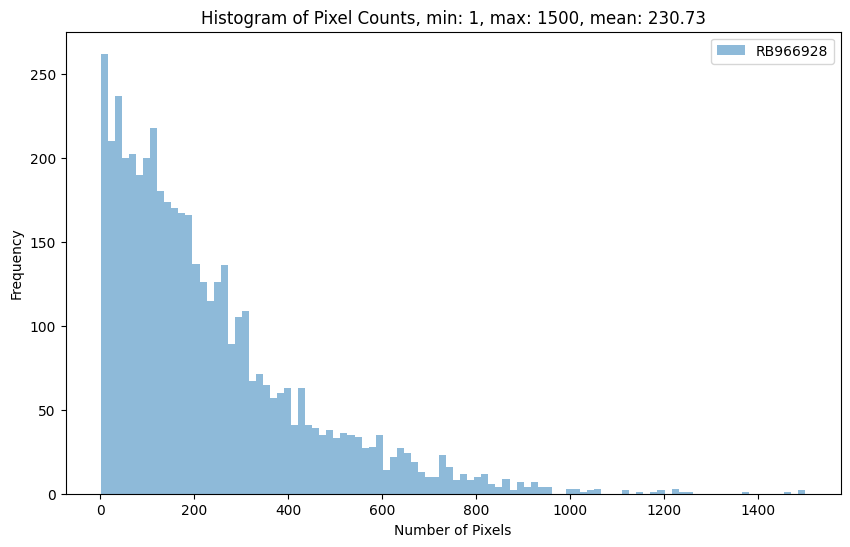

number of pixels < 100: 409 / 978


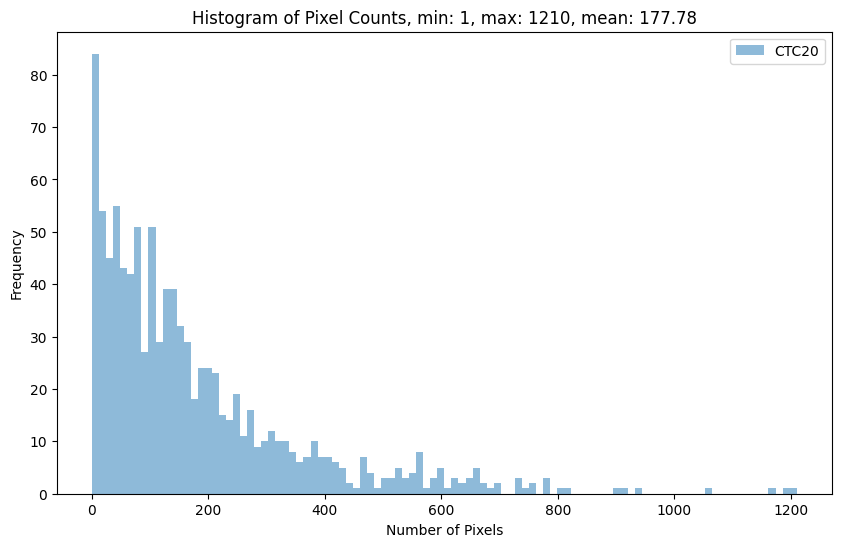

number of pixels < 100: 414 / 1602


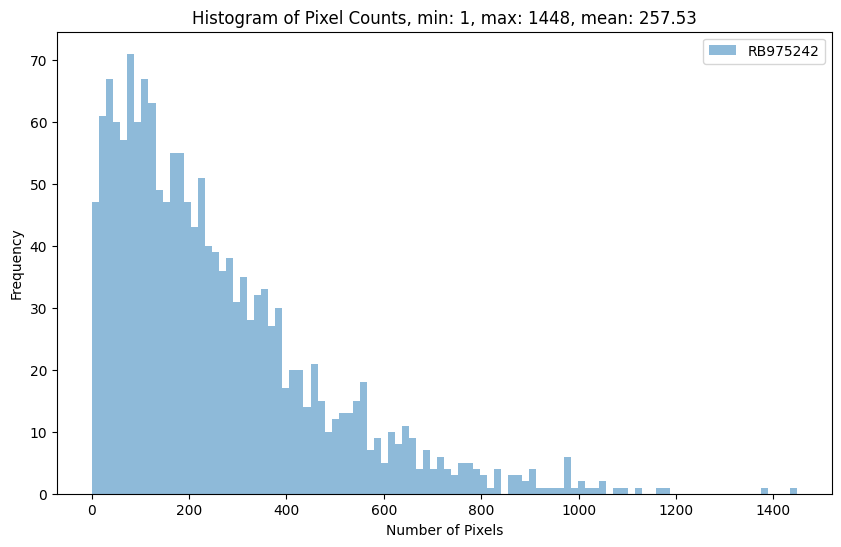

number of pixels < 100: 380 / 1394


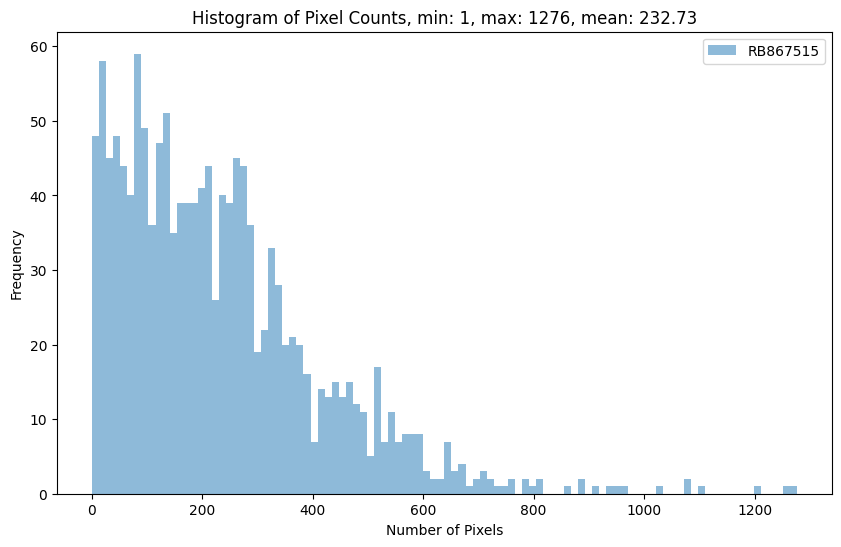

number of pixels < 100: 961 / 3821


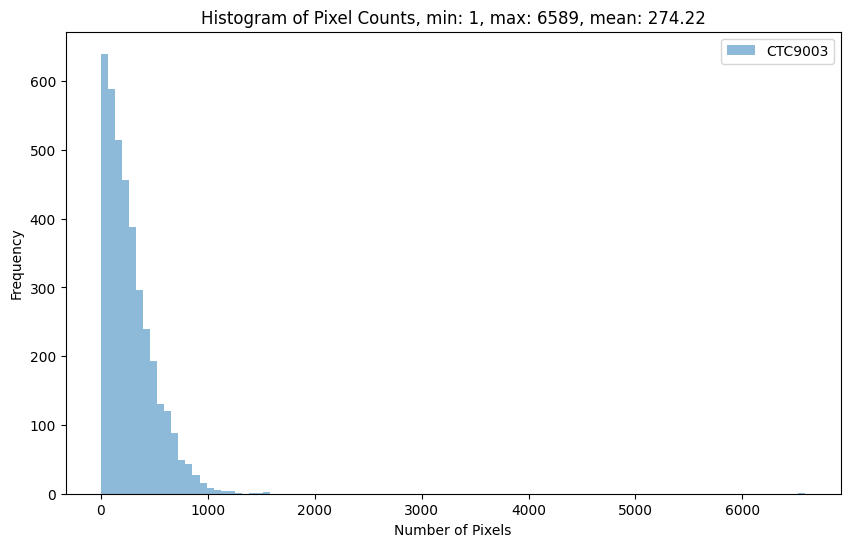

number of pixels < 100: 337 / 1048


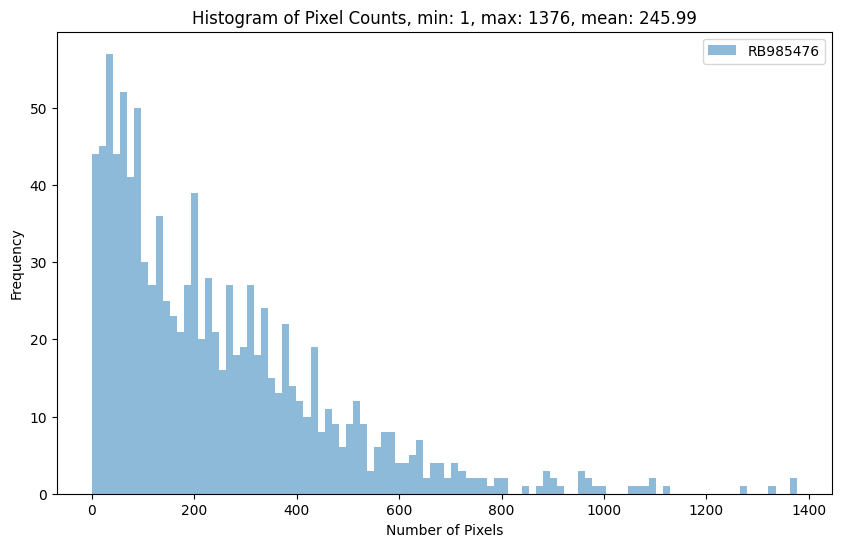

number of pixels < 100: 1097 / 3483


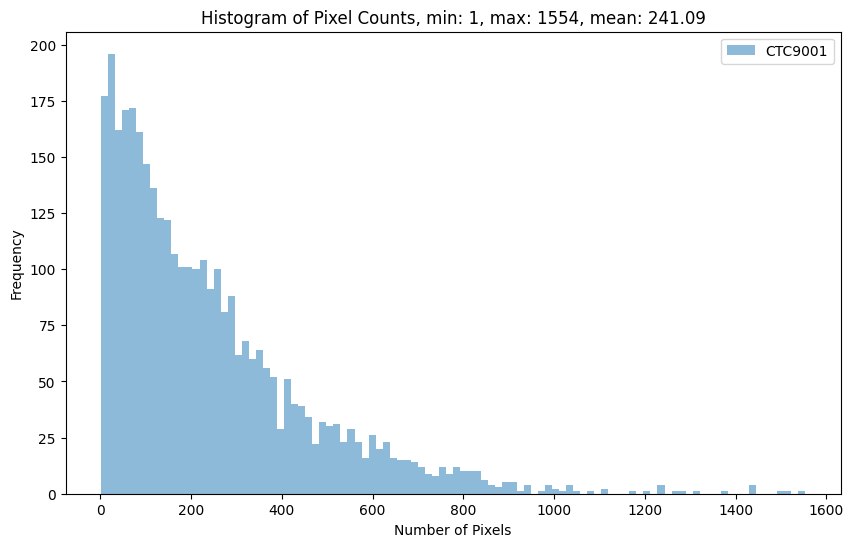

number of pixels < 100: 334 / 1120


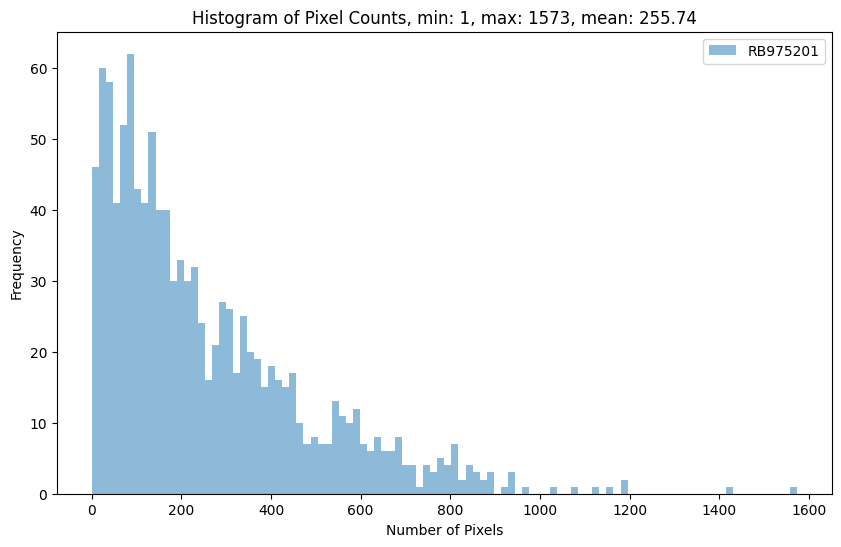

number of pixels < 100: 534 / 2502


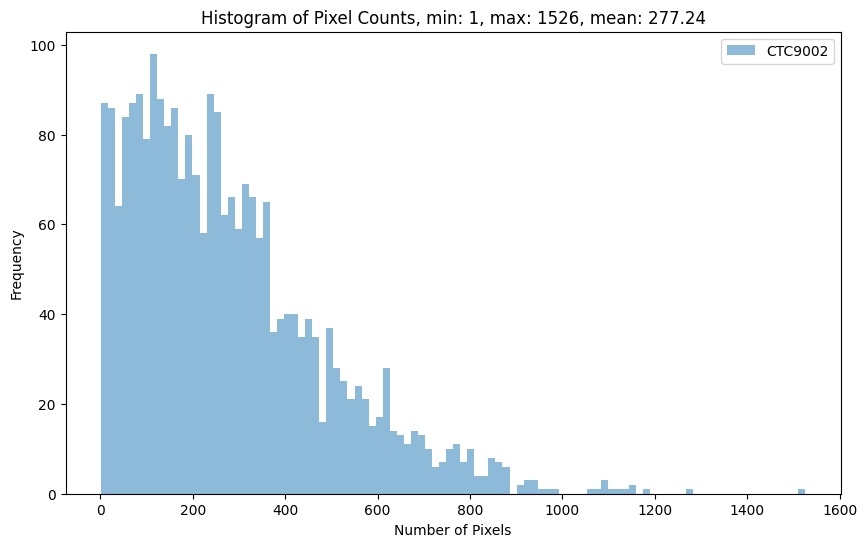

number of pixels < 100: 245 / 932


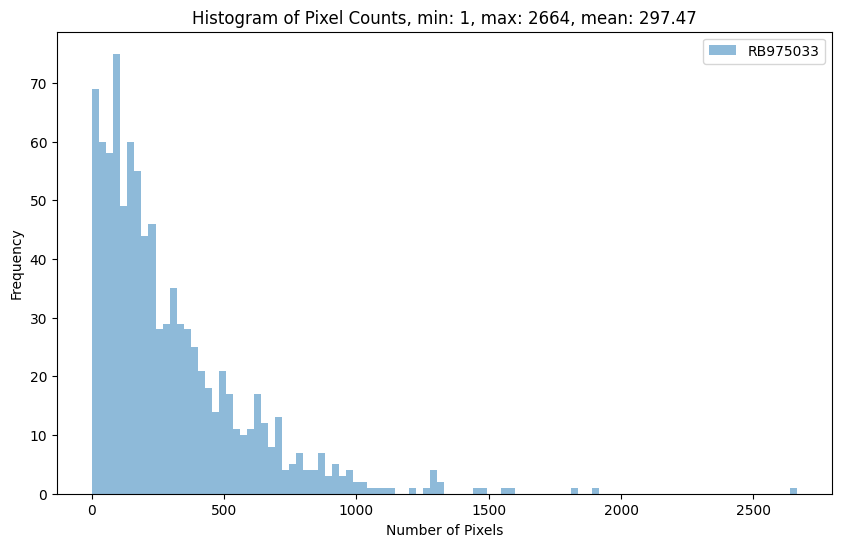

number of pixels < 100: 4247 / 12535


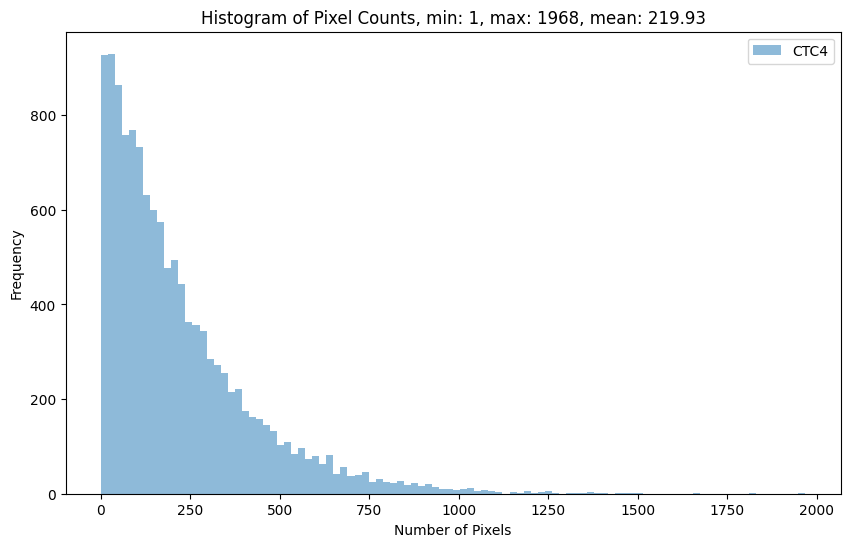

number of pixels < 100: 338 / 1032


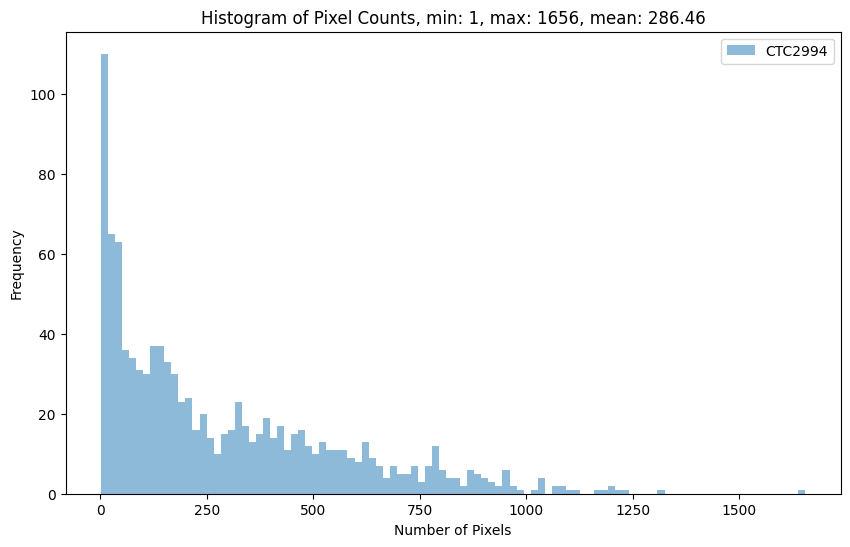

number of pixels < 100: 369 / 916


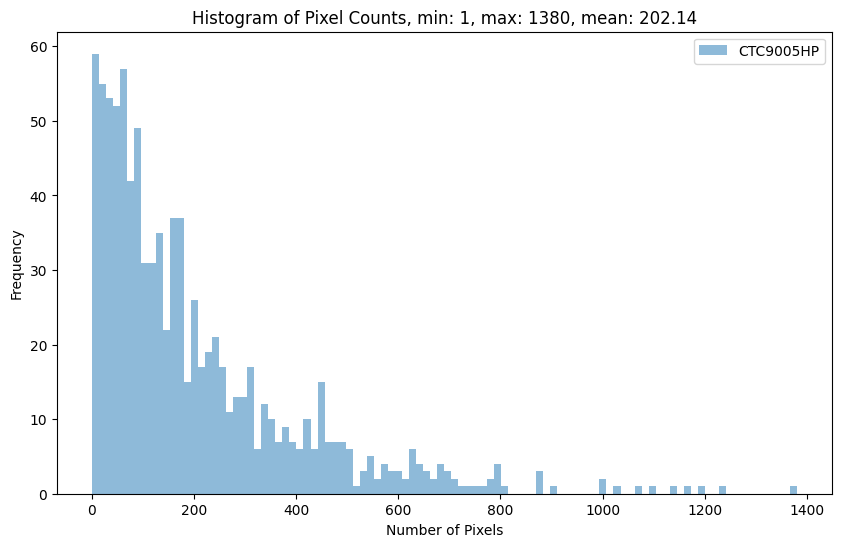

number of pixels < 100: 400 / 1432


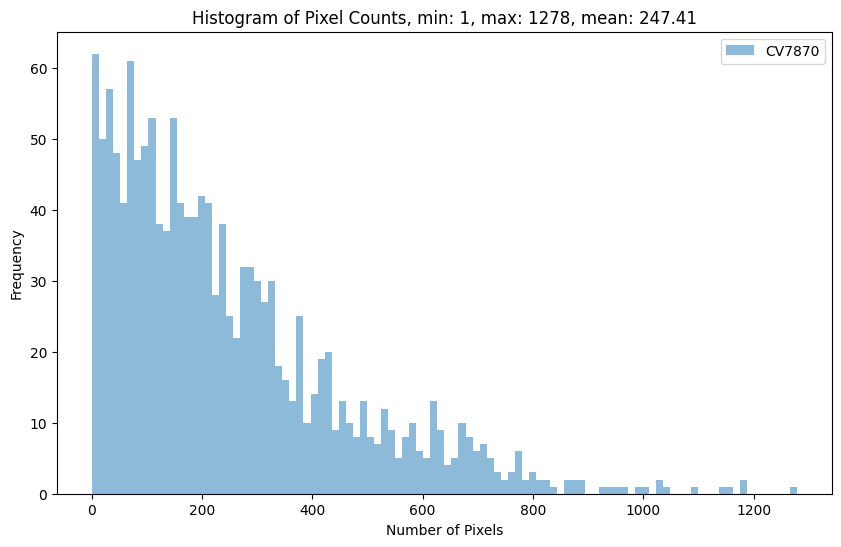

In [35]:
from matplotlib import pyplot as plt
con = {reverse_linear_encoder[k]: v for k, v in class_sample_pixel_summary.items()}
# Prepare the plot

# For each label in the dictionary, plot a histogram of its log-transformed pixel count distribution
for label, pixel_counts in con.items():
    plt.figure(figsize=(10, 6))
    data = np.array(pixel_counts)/(15*12)
    plt.hist(data, bins=100, alpha=0.5, label=label)

    dmin = np.min(data)
    dmax = np.max(data)
    dmean = np.mean(data)
    # number of pixels < 10
    num_samples = len(pixel_counts)
    print(f'number of pixels < 100: {np.sum(data < 100)} / {num_samples}')
    # Add labels and title
    plt.xlabel('Number of Pixels')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Pixel Counts, min: {dmin:.0f}, max: {dmax:.0f}, mean: {dmean:.2f}')
    plt.legend(loc='upper right')

    # Display the plot
    plt.show()

In [25]:
np.max(con['RB966928'])

1500.0

In [2]:
# pixel-wised class weights
total_pixels = np.sum(list(class_counter_pixel.values()))
n_classes = len(class_counter_pixel)

class_weights_pixel = {k: total_pixels / (n_classes * v) for k, v in class_counter_pixel.items()}
# sort the dic by key
class_weights_pixel = dict(sorted(class_weights_pixel.items()))
class_weights_pixel

{0: 2.078851303421863,
 1: 1.2208126537377917,
 2: 0.8127441908948647,
 3: 0.7513995468742982,
 4: 0.6508978026001478,
 5: 0.6536399637239136,
 6: 1.9506633761684948,
 7: 1.0186648354129837,
 8: 1.1132738838906995,
 9: 0.7919377056107961,
 10: 1.3045084244423468,
 11: 1.2602517419443027,
 12: 0.8751068252825089,
 13: 1.4000249391761204}

In [3]:
# sample-wised class weights
total_samples = np.sum(list(class_counter.values()))
n_classes = len(class_counter)

class_weights = {k: total_samples / (n_classes * v) for k, v in class_counter.items()}
# sort the dic by key
class_weights = dict(sorted(class_weights.items()))
class_weights

{0: 1.494736072525223,
 1: 1.4164472772620202,
 2: 0.7301785714285715,
 3: 0.7301785714285715,
 4: 0.7301785714285715,
 5: 0.7301785714285715,
 6: 1.5960187353629978,
 7: 1.0205151242887092,
 8: 1.0483540149728232,
 9: 0.7301785714285715,
 10: 1.5685898419518183,
 11: 1.3050555342780543,
 12: 0.9121531185865976,
 13: 1.3948014735980352}

In [4]:
# sort the class_counter by the key
sorted_class_counter = dict(sorted(class_counter.items(), key=lambda item: item[0]))
sorted_class_counter

{0: 977,
 1: 1031,
 2: 2000,
 3: 2000,
 4: 2000,
 5: 2000,
 6: 915,
 7: 1431,
 8: 1393,
 9: 2000,
 10: 931,
 11: 1119,
 12: 1601,
 13: 1047}

: 

In [6]:
reverse_linear_encoder

{0: 'CTC20',
 1: 'CTC2994',
 2: 'CTC4',
 3: 'CTC9001',
 4: 'CTC9002',
 5: 'CTC9003',
 6: 'CTC9005HP',
 7: 'CV7870',
 8: 'RB867515',
 9: 'RB966928',
 10: 'RB975033',
 11: 'RB975201',
 12: 'RB975242',
 13: 'RB985476'}

In [26]:
from utils.dataset import CTCdataset
ds = CTCdataset('train')

In [27]:
out_cls = {}
for out in ds:
    data = out['data']
    label = out['label']
    time = out['time']
    if label not in out_cls:
        out_cls[label] = [data]
    else:
        out_cls[label].append(data)

In [28]:
import numpy as np
class_0 = np.concatenate(out_cls[0])
class_1 = np.concatenate(out_cls[1])

In [19]:
a = (class_0 == 0).sum(axis=0) == 0

In [25]:
(class_1 == 0).sum() / len(class_1.reshape(-1))

0.11870102334383005

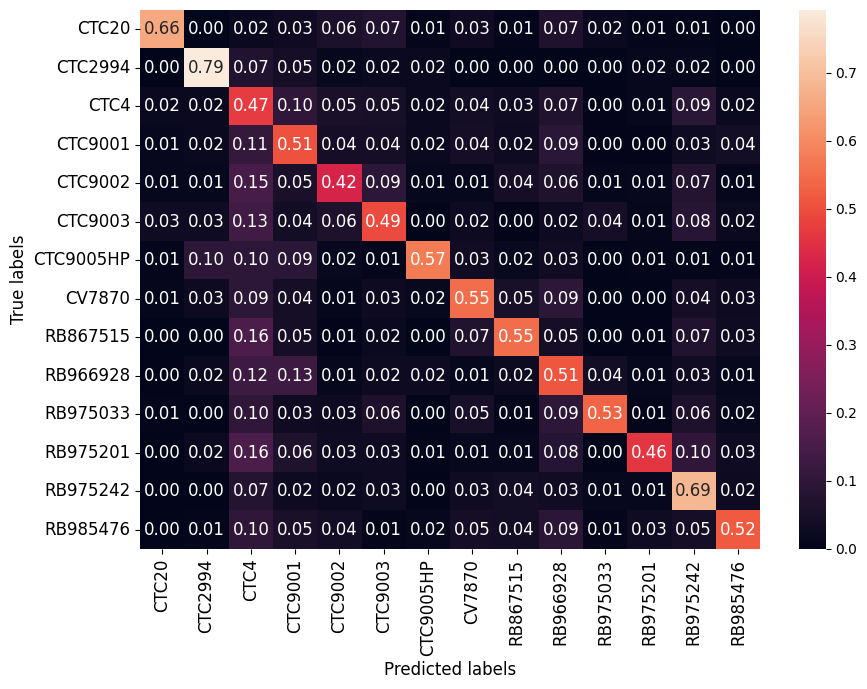

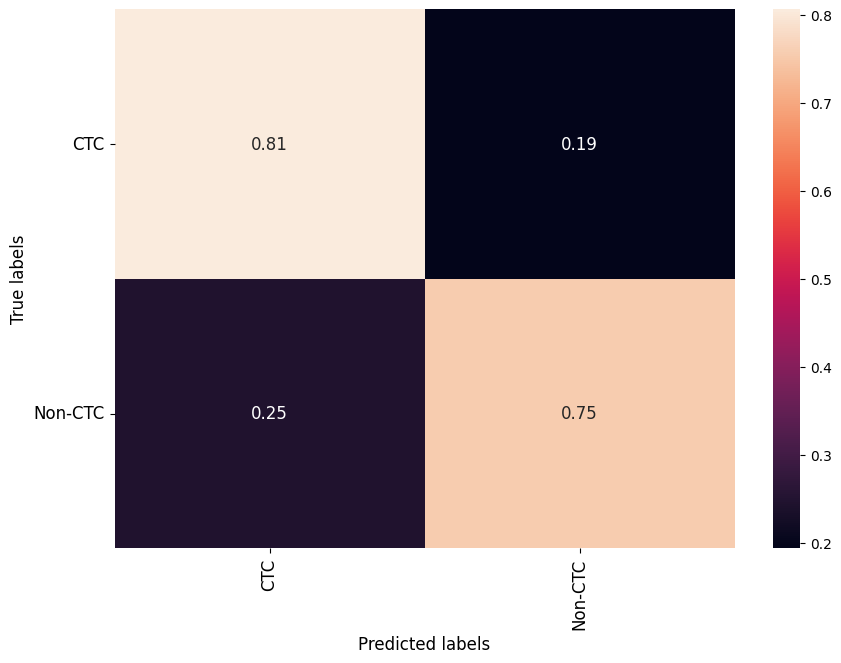

In [3]:
import numpy as np
from utils.tools import plot_save_confusion_matrix
from utils.settings.config import LINEAR_ENCODER


def show_results(results):
    cm = np.load(results)
    # Summing the first 7 rows and columns (Class 1)
    class1_true = np.sum(cm[:7, :7])  # True Positives for Class 1
    class1_false = np.sum(cm[:7, 7:])  # False Positives and False Negatives for Class 1

    # Summing the last 7 rows and columns (Class 2)
    class2_true = np.sum(cm[7:, 7:])  # True Positives for Class 2
    class2_false = np.sum(cm[7:, :7])  # False Positives and False Negatives for Class 2

    # Constructing the new 2x2 confusion matrix
    new_confusion_matrix = np.array([
        [class1_true, class1_false],  # Class 1
        [class2_false, class2_true]   # Class 2
    ])
    label_encoder = {v: k for k, v in LINEAR_ENCODER.items()}

    ticks = [label_encoder[i] for i in range(len(label_encoder))]

    plot_save_confusion_matrix(cm, ticks, fontsize=12,norm = True)
    plot_save_confusion_matrix(new_confusion_matrix, ['CTC','Non-CTC'], fontsize=12, norm = True)
# show_results('logs/cnn/cnn-clean-ds-shuffled/run_20240927153248/cm_epoch83.npy')
show_results('logs/tfcnn/tf-cnn-clean-ds-shuffled/Best_model/cm_epoch0.npy')

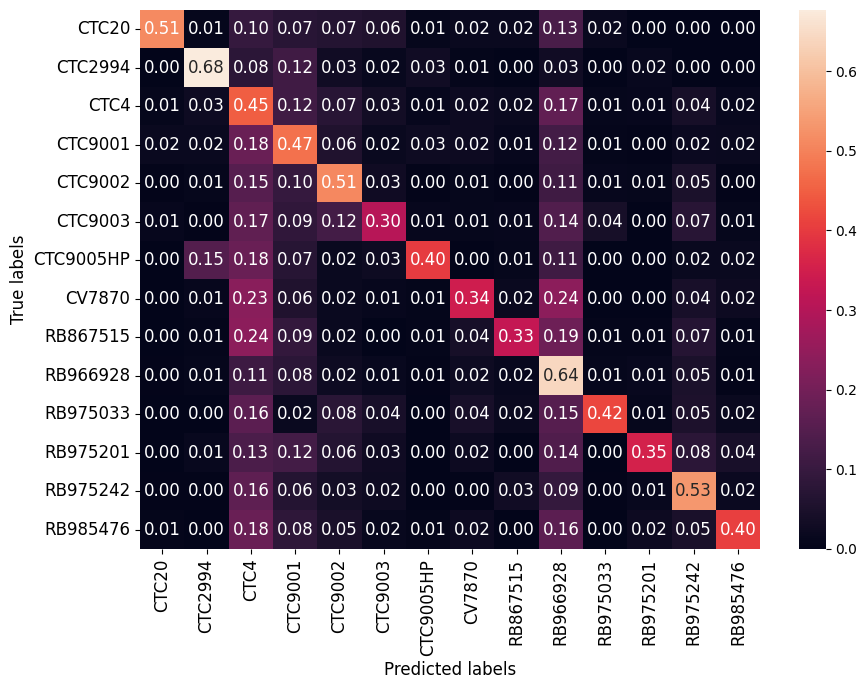

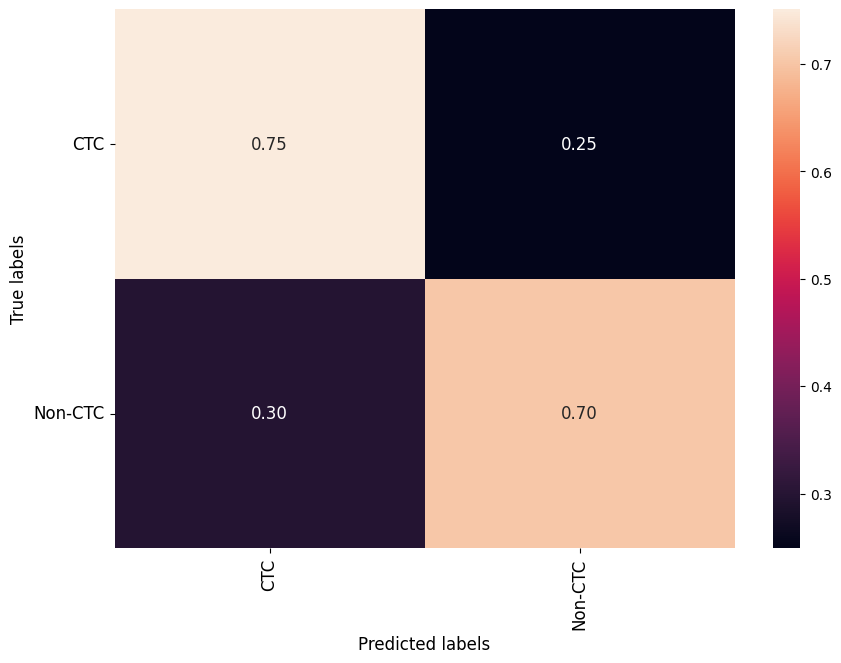

In [1]:
import numpy as np
from utils.tools import plot_save_confusion_matrix
from utils.settings.config import LINEAR_ENCODER


def show_results(results):
    cm = np.load(results)
    # Summing the first 7 rows and columns (Class 1)
    class1_true = np.sum(cm[:7, :7])  # True Positives for Class 1
    class1_false = np.sum(cm[:7, 7:])  # False Positives and False Negatives for Class 1

    # Summing the last 7 rows and columns (Class 2)
    class2_true = np.sum(cm[7:, 7:])  # True Positives for Class 2
    class2_false = np.sum(cm[7:, :7])  # False Positives and False Negatives for Class 2

    # Constructing the new 2x2 confusion matrix
    new_confusion_matrix = np.array([
        [class1_true, class1_false],  # Class 1
        [class2_false, class2_true]   # Class 2
    ])
    label_encoder = {v: k for k, v in LINEAR_ENCODER.items()}

    ticks = [label_encoder[i] for i in range(len(label_encoder))]

    plot_save_confusion_matrix(cm, ticks, fontsize=12,norm = True)
    plot_save_confusion_matrix(new_confusion_matrix, ['CTC','Non-CTC'], fontsize=12, norm = True)
# show_results('logs/cnn/cnn-clean-ds-shuffled/run_20240927153248/cm_epoch83.npy')
show_results('logs/tfcnn/preprocessed/run_2024-10-11-12h-26:11/cm_epoch144.npy')

# Shuffle training dataset in pixel level

In [ ]:
import numpy as np
from pathlib import Path
import random
from collections import defaultdict
from utils.settings.config import LINEAR_ENCODER

# Define paths and parameters
data_dir = Path('./data/dataset/train')
output_dir = Path('./data//dataset/train_shuffled_pixels')
output_dir.mkdir(exist_ok=True, parents=True)


# Filter data function to control max samples per class
def filter_data(data_paths, max_samples_per_class):
    label_dict = defaultdict(list)
    for path in data_paths:
        label = path.parent.name
        label_dict[label].append(path)
    
    # Limit the number of samples per label
    for label, paths in label_dict.items():
        if len(paths) > max_samples_per_class:
            label_dict[label] = random.sample(paths, max_samples_per_class)
    
    # Flatten the dictionary back into a list
    filtered_paths = [path for paths in label_dict.values() for path in paths]
    return filtered_paths

# Collect all data paths
data_paths = list(data_dir.glob('**/*_data.npy'))

# Apply filtering to control the number of samples per class
max_samples_per_class = 2000  # Example value, adjust as needed
filtered_paths = filter_data(data_paths, max_samples_per_class)

# Collect pixels and their corresponding labels
pixel_pool = []

for path in filtered_paths:
    label = path.parent.name
    class_id = LINEAR_ENCODER[label]
    data = np.load(path)  # Assuming data is of shape (75, 15, 12)
    time_path = (path.parent / path.stem.replace('data', 'time')).with_suffix('.npy')
    time_data = np.load(time_path)  # Load time data corresponding to the pixel data

    # Combine pixel data with its corresponding label and time data
    for pixel_idx in range(data.shape[0]):
        pixel_data = data[pixel_idx]  # Shape: (15, 12)
        # time_pixel_data = time_data[pixel_idx]  # Corresponding time data for the pixel
        pixel_pool.append((pixel_data, time_data, class_id))

# Shuffle the entire pool of pixels
random.shuffle(pixel_pool)

# Split the shuffled pool into files with a random number of pixels (35 to 600)
current_index = 0
file_count = 0

while current_index < len(pixel_pool):
    # Randomly determine the number of pixels for this file
    num_pixels = random.randint(35, 600)
    
    # Ensure we do not exceed the available pixels
    end_index = min(current_index + num_pixels, len(pixel_pool))
    
    # Extract the subset of pixels
    subset = pixel_pool[current_index:end_index]
    current_index = end_index

    # Save the subset to a new file
    pixel_data = np.array([item[0] for item in subset])  # Shape: (num_pixels, 15, 12)
    time_data = np.array([item[1] for item in subset])   # Corresponding time data
    pixel_labels = np.array([item[2] for item in subset])  # Shape: (num_pixels,)

    # Save as numpy files
    np.save(output_dir / f'pixels_{file_count}_data.npy', pixel_data)
    np.save(output_dir / f'pixels_{file_count}_time.npy', time_data)
    np.save(output_dir / f'pixels_{file_count}_labels.npy', pixel_labels)
    file_count += 1
    # print the progress evert 100 files, indicate the number of pixel saved
    if end_index % 1000000 == 0:
        print(f'Saved {file_count} files with {end_index} / {len(pixel_pool)} pixels.')

print(f'Saved {file_count} files with shuffled pixels.')

In [8]:
from utils.dataset import CTCdataset_train
from collections import defaultdict
from torch.utils.data import DataLoader
import numpy as np
def count_pixels_in_dataset(dataset):
    """
    Counts the number of pixels in each class within the dataset.

    Parameters:
    - dataset: An instance of CTCdataset_train

    Returns:
    - class_counts: Dictionary with class labels as keys and pixel counts as values
    """
    class_counts = defaultdict(int)

    # Create a DataLoader to iterate through the dataset
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Iterate over each batch in the dataloader
    for batch in dataloader:
        labels = batch['label'].numpy().flatten()  # Flatten to a 1D array of labels
        
        # Count occurrences of each label in the batch
        unique, counts = np.unique(labels, return_counts=True)
        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    return class_counts
def count_pixels_in_dataset(dataset):
    """
    Counts the number of pixels in each class within the dataset.

    Parameters:
    - dataset: An instance of CTCdataset_train

    Returns:
    - class_counts: Dictionary with class labels as keys and pixel counts as values
    """
    class_counts = defaultdict(int)

    # Create a DataLoader to iterate through the dataset
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    # Iterate over each batch in the dataloader
    for batch in dataloader:
        labels = batch['label'].numpy().flatten()  # Flatten to a 1D array of labels
        
        # Count occurrences of each label in the batch
        unique, counts = np.unique(labels, return_counts=True)
        for class_id, count in zip(unique, counts):
            class_counts[class_id] += count

    return class_counts
dataset = CTCdataset_train()
class_counts = count_pixels_in_dataset(dataset)

# Print the counts for each class
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} pixels")

Class 0: 173865 pixels
Class 1: 295628 pixels
Class 2: 432964 pixels
Class 3: 481361 pixels
Class 4: 553451 pixels
Class 5: 547238 pixels
Class 6: 185159 pixels
Class 7: 354294 pixels
Class 8: 324422 pixels
Class 9: 460983 pixels
Class 10: 277243 pixels
Class 11: 286428 pixels
Class 12: 412565 pixels
Class 13: 257798 pixels


In [9]:
import numpy as np
def compute_class_weights(class_counter_pixel):
    # pixel-wised class weights
    total_pixels = np.sum(list(class_counter_pixel.values()))
    n_classes = len(class_counter_pixel)

    class_weights_pixel = {k: total_pixels / (n_classes * v) for k, v in class_counter_pixel.items()}
    # sort the dic by key
    class_weights_pixel = dict(sorted(class_weights_pixel.items()))
    return class_weights_pixel
compute_class_weights(class_counts)

{0: 2.071968399127402,
 1: 1.2185678816427594,
 2: 0.8320386584433942,
 3: 0.7483838236049155,
 4: 0.6509027641368174,
 5: 0.6582927094139766,
 6: 1.9455861487385744,
 7: 1.0167905347374941,
 8: 1.110414169551651,
 9: 0.7814665306839639,
 10: 1.299375586450463,
 11: 1.2577079954274224,
 12: 0.8731782524312186,
 13: 1.3973839429098973}